# Comparing demographic criteria on credit score data

In this notebook, we look at some aggregate statistics on credit score data.

In [1]:
import math
import numpy as np
import pandas as pd
import pylab
from criteria import CriteriaData
from matplotlib import rc
from cycler import cycler
import matplotlib.ticker as mtick

## Parse data

In [2]:
# Adjust these as needed
DATA_DIR='data/'
FIGURE_DIR='../../figures/'

def cleanup_frame(frame):
    """Rename and re-order columns"""
    frame = frame.rename(columns={'Non- Hispanic white': 'White'})
    frame = frame.reindex(['Asian', 'Black', 'Hispanic', 'White'], axis=1)
    return frame

def read_totals():
    """Read the total number of people of each race"""
    frame = cleanup_frame(pd.read_csv(DATA_DIR+files['overall'], index_col=0))
    return {r:frame[r]['SSA'] for r in frame.columns}

def parse_data(data_dir=DATA_DIR):
    """Parse sqf data set."""

    cdfs = cleanup_frame(pd.read_csv(data_dir+files['cdf_by_race'], index_col=0))
    performance = 100-cleanup_frame(pd.read_csv(data_dir+files['performance_by_race'], index_col=0))
    return (cdfs/100., performance/100.)

files = dict(cdf_by_race = 'transrisk_cdf_by_race_ssa.csv',
             performance_by_race = 'transrisk_performance_by_race_ssa.csv',
             overall = 'totals.csv')

cdfs = cleanup_frame(pd.read_csv(DATA_DIR+files['cdf_by_race'], index_col=0))
performance = 100-cleanup_frame(pd.read_csv(DATA_DIR+files['performance_by_race'], index_col=0))

data_pair = parse_data()
totals = read_totals()
data = CriteriaData(data_pair[0], data_pair[1], totals)

## Plots

In [3]:
pct_fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
pct_formatter = mtick.FormatStrFormatter(pct_fmt)

def set_pct_formatter(s):
    if s == 'x':
        pylab.gca().xaxis.set_major_formatter(pct_formatter)
    elif s == 'y':
        pylab.gca().yaxis.set_major_formatter(pct_formatter)


rc('axes', prop_cycle=(cycler('color', ['b', 'g', 'c', 'r', 'y']) +
                           cycler('linestyle', ['-', '--', '-.', ':', '-'])))
rc('font',  size='17')
rc('axes', labelsize='large')
rc('lines', linewidth=3)
rc('text', usetex=False)
titlekws = dict(y=1.03)

def index_and_interpolate(series, x):
    loc = series.index.get_loc(x, 'ffill')
    return (series[series.index[loc+1]] * (x - series.index[loc]) + series[series.index[loc]] * (series.index[loc+1]-x)) * 1. / (series.index[loc+1] - series.index[loc])

def find_x_for_y(xs, ys, y):
    xs = np.array(xs)
    ys = np.array(ys)
    for i in range(len(xs)-1):
        (xold, yold) = xs[i], ys[i]
        (xnew, ynew) = xs[i+1], ys[i+1]
        if (yold - y) * (ynew - y) < 0:
            x = xold + ((y - yold) / (ynew - yold)) * (xnew - xold)
            return x
    return None


class CriteriaPlotter(object):
    
    def __init__(self, data, labels={}):
        """data should be a CriteriaData instance"""
        self.data = data
        self.columns = self.data.columns
        self.labels = dict(success='non-default',
              success_people = 'non-defaulters',
              score='credit score',
              longscore='credit score',
              fail_people='defaulters',
              classifier_outcome='loan')
        self.funcs = {}

    @property
    def truepos_text(self):
        return "Fraction %(success_people)s\ngetting %(classifier_outcome)s" % self.labels
    
    @property
    def falsepos_text(self):
        return "Fraction %(fail_people)s getting %(classifier_outcome)s" % self.labels
        
    def plot_curves(self, cutoff_sets=[], regular_labels=True, xlim=[0., 0.4], ylim=[0.4,1]):
        """Draws the (frac non-defaulters getting loan, frac defaulters getting loan) curve."""
        good, bad = self.data.compute_curves()
        for group in self.columns:
            pylab.plot(bad[group].values, good[group].values, label=group if regular_labels else None)
        for ctype, val, new_kws in cutoff_sets:
            kws = dict(color='k', marker='x', s=40, linewidths=3, zorder=3,)
            kws.update(new_kws)
            if ctype == 'cutoffs':
                pylab.scatter([index_and_interpolate(bad[group], val[group]) for group in val],
                          [index_and_interpolate(good[group], val[group]) for group in val],
                          **kws)
            elif ctype == 'y':
                pylab.scatter([find_x_for_y(bad[group], good[group], val) for group in good],
                          [val] * len(good.keys()), **kws)
            elif ctype == 'xy':
                pylab.scatter(val[0], val[1], **kws)
        pylab.legend(loc=0)
        pylab.ylabel(self.truepos_text)
        pylab.xlabel(self.falsepos_text)
        
    def plot_roc_curves(self, kwargs):
        xlim = kwargs.get('xlim')
        ylim = kwargs.get('ylim')
        pylab.clf()
        pylab.figure(figsize=(6, 5))
        self.plot_curves()
        pylab.xlim(xlim)
        pylab.ylim(ylim)
        pylab.title('ROC curve of credit score')
        pylab.tight_layout()
        pylab.savefig(FIGURE_DIR + ('credit_roc_curve_%s_%s.svg' % (xlim, ylim)).replace(' ', ''))
        pylab.show()
        
    def plot_comparison(self, target_rate, kwargs):
        """Draw thresholds for various different criteria."""
        xlim = kwargs.get('xlim')
        ylim = kwargs.get('ylim')
        s = kwargs.get('s', 1)
        pylab.clf()
        pylab.figure(figsize=(10, 5))
        opt_point = self.data.two_sided_optimum(target_rate)
        self.plot_curves([('cutoffs', self.data.profit_cutoffs(target_rate),
                            dict(marker='^',label='Max profit', s=70*s)),
                           ('cutoffs', self.data.fixed_cutoffs(target_rate, True),
                            dict(label='Single threshold', marker='o', color='g',s=100)),
                          ('y', self.data.get_best_demographic(target_rate),
                            dict(marker='x',label='Independence', s=130*s, color='purple')),
                          ('xy', ([opt_point[1]], [opt_point[0]]),
                           dict(marker='+', label='Separation', s=180*s, color='brown', zorder=4, linewidth=3)),
                         ], regular_labels=False)
        pylab.title('ROC curve with thresholds')
        pylab.xlim(xlim)
        pylab.ylim(ylim)        
        pylab.tight_layout()
        pylab.savefig(FIGURE_DIR + 'credit_roc_curve_with_thresholds.svg')
        pylab.show()

    def plot_performance(self, raw=False, groups=None):
        """Draws the (score, non-default rate) curve.

        If raw = True, the x-axis has the raw score.  Otherwise, it's the
        within-group score percentile.
        """
        if groups is None:
            groups = self.data.columns
        for group in groups:
            counts = plotter.data.cdfs[group] * totals[group]
            pos_counts = counts.multiply(plotter.data.performance[group])            
            if raw:
                pylab.plot(self.data.performance[group].index, 100*self.data.performance[group], label=group)
            else:
                pylab.plot(100*self.data.cdfs[group], 100*self.data.performance[group], label=group)
        if raw:
            idx = self.data.performance[group].index
            pylab.xlim((idx.min(), idx.max()))
            pylab.xlabel('%(longscore)s' % self.labels)
        else:
            if self.data.flipped:
                pylab.gca().invert_xaxis()
            pylab.xlabel('Within-group score percentile' % self.labels)
        pylab.ylabel(('%(success)s rate' % self.labels).capitalize())
        set_pct_formatter('y')
        pylab.legend(loc=0)

    def plot_pair(self, target):
        """Plots performance with raw=True and raw=False in two subplots."""
        pylab.clf()
        pylab.figure(figsize=(10, 5))
        pylab.subplot(121)
        self.plot_performance(raw=True)
        pylab.hlines(target*100, self.data.cdfs.index.min(), self.data.cdfs.index.max(), linewidth=1, colors='k')
        pylab.subplot(122)
        self.plot_performance()
        pylab.hlines(target*100, 0, 100, linewidth=1, colors='k')
        pylab.tight_layout()
        pylab.savefig(FIGURE_DIR + 'credit_performance.svg')
        pylab.show()
        
    def plot_cdf(self):
        """Draws score distribution in each group."""
        pylab.clf()
        pylab.figure(figsize=(6, 5))
        groups = self.data.columns
        for group in groups:
            counts = plotter.data.cdfs[group] * totals[group]
            pos_counts = counts.multiply(plotter.data.performance[group])            
            pylab.plot(self.data.performance[group].index, self.data.cdfs[group], label=group)
        pylab.title('Cumulative density')
        pylab.xlabel('Score')
        pylab.ylabel('Density')
        pylab.legend(loc=0)
        pylab.tight_layout()
        pylab.savefig(FIGURE_DIR + 'credit_cdf.svg')
        pylab.show()


## CDF of score distribution by group

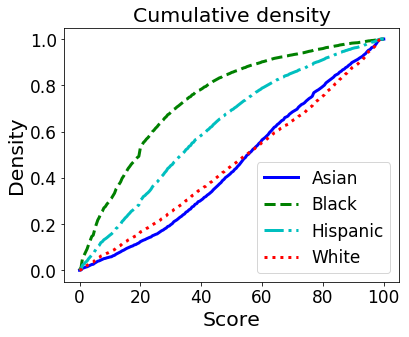

In [4]:
plotter = CriteriaPlotter(data)
plotter.plot_cdf()

## ROC curves by group

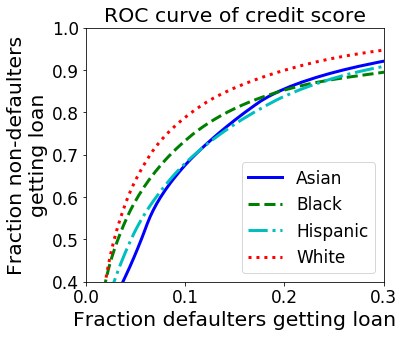

In [5]:
plotter.plot_roc_curves(dict(xlim=(0, 0.3), ylim=(0.4, 1.0)))

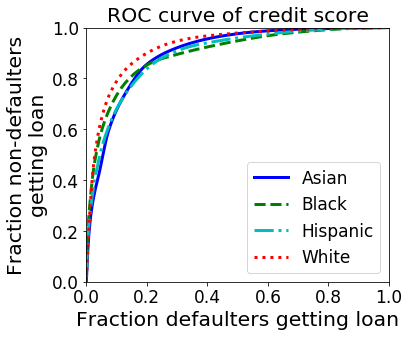

In [6]:
plotter.plot_roc_curves(dict(xlim=(0, 1), ylim=(0, 1)))

## Thresholds for different criteria

To plot the thresholds for different criteria, we need to specify a cost for false positives and false negatives. The only relevant parameter is their ratio, which is determined by the 'payback probability' at which it becomes profitable to lend. Below we call this `CUTOFF`. The value `CUTOFF = 5/6.`, for example, indicates that a default is 6 times as costly to the bank as the profit generated from a successful lending outcome.

In [7]:
CUTOFF = 5/6.

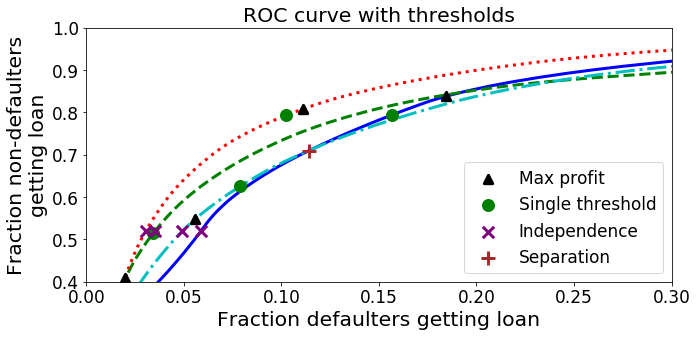

In [8]:
plotter.plot_comparison(CUTOFF, dict(xlim=(0, 0.3), ylim=(0.4, 1.0)))

## Calibration plots

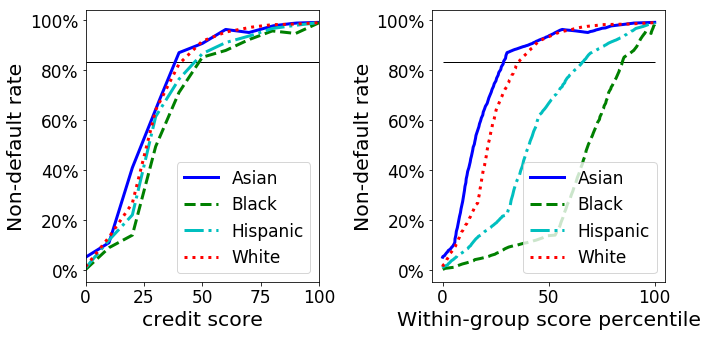

In [9]:
plotter.plot_pair(CUTOFF)